# Chest X-Ray Pneumonia Classifier

A CNN-based binary classifier for detecting pneumonia from chest X-ray images using TensorFlow/Keras.

In [28]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    classification_report
)

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import kagglehub

tf.random.set_seed(42)
np.random.seed(42)

## Step 1: Dataset Download and Exploration

In [29]:
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print(f"Dataset path: {path}")

os.makedirs("plots", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("splits", exist_ok=True)

Dataset path: C:\Users\aliza\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2


In [ ]:
splits = ["train", "val", "test"]
classes = ["NORMAL", "PNEUMONIA"]

print("Image counts per split:")
total = 0
for split in splits:
    normal = len(os.listdir(os.path.join(path, "chest_xray", split, "NORMAL")))
    pneumonia = len(os.listdir(os.path.join(path, "chest_xray", split, "PNEUMONIA")))
    split_total = normal + pneumonia
    total += split_total
    print(f"  {split}: {normal} normal, {pneumonia} pneumonia, {split_total} total")
print(f"Total: {total} images")

Image counts per split:
  train: 1341 normal, 3875 pneumonia, 5216 total
  val: 8 normal, 8 pneumonia, 16 total
  test: 234 normal, 390 pneumonia, 624 total
Total: 5856 images


## Step 2: Patient-wise Train/Val/Test Splits

Important: We split by patient ID to prevent data leakage between splits.

In [31]:
# Extract patient ID from filename
patient_pattern = re.compile(r'^(person\d+|patient\d+|IM-\d+|NORMAL2?-\d+|[\w]+-\d+)', re.IGNORECASE)

def extract_patient_id(filepath: str) -> str:
    filename = os.path.basename(filepath)
    match = patient_pattern.match(filename)
    if match:
        return match.group(1).lower()
    parts = filename.replace('.jpeg', '').replace('.jpg', '').replace('.png', '').split('_')
    return parts[0].lower() if parts else filename

# Build dataframe with all images
data_records = []
for split in splits:
    for cls in classes:
        dir_path = os.path.join(path, "chest_xray", split, cls)
        if os.path.exists(dir_path):
            for f in os.listdir(dir_path):
                if f.lower().endswith(('.jpeg', '.jpg', '.png')):
                    filepath = os.path.join(dir_path, f)
                    data_records.append({
                        "filepath": filepath,
                        "label": cls,
                        "patient_id": extract_patient_id(filepath)
                    })

df = pd.DataFrame(data_records)
print(f"Total images: {len(df)}")
print(f"Unique patients: {df['patient_id'].nunique()}")
print(f"Label distribution: {df['label'].value_counts().to_dict()}")

Total images: 5856
Unique patients: 3174
Label distribution: {'PNEUMONIA': 4273, 'NORMAL': 1583}


C:\Users\aliza\AppData\Local\Temp\ipykernel_28004\412866187.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['label'], palette='viridis')


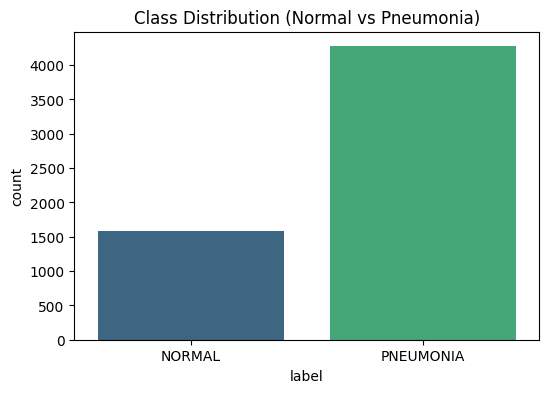

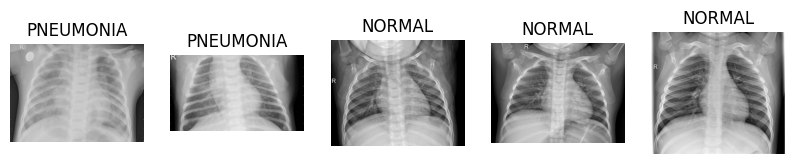

In [32]:
plt.figure(figsize=(6, 4))
sns.countplot(x=df['label'], palette='viridis')
plt.title('Class Distribution (Normal vs Pneumonia)')
plt.show()

# Visualize Samples
def show_samples(df, n=3):
    plt.figure(figsize=(10, 4))
    for i, (_, row) in enumerate(df.sample(n).iterrows()):
        img = plt.imread(row['filepath'])
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(row['label'])
        plt.axis('off')
    plt.show()

show_samples(df, n=5)

In [ ]:
patient_df = df.groupby("patient_id").agg({
    "label": "first",
    "filepath": "count"
}).rename(columns={"filepath": "image_count"}).reset_index()

train_patients, temp_patients = train_test_split(
    patient_df, test_size=0.30, stratify=patient_df["label"], random_state=42
)
val_patients, test_patients = train_test_split(
    temp_patients, test_size=0.50, stratify=temp_patients["label"], random_state=42
)

train_ids = set(train_patients["patient_id"])
val_ids = set(val_patients["patient_id"])
test_ids = set(test_patients["patient_id"])

df_train = df[df["patient_id"].isin(train_ids)].copy()
df_val = df[df["patient_id"].isin(val_ids)].copy()
df_test = df[df["patient_id"].isin(test_ids)].copy()

print("Patient-wise Split Results:")
for name, split_df in [("train", df_train), ("val", df_val), ("test", df_test)]:
    n_patients = split_df["patient_id"].nunique()
    n_images = len(split_df)
    n_normal = (split_df["label"] == "NORMAL").sum()
    n_pneumonia = (split_df["label"] == "PNEUMONIA").sum()
    print(f"  {name}: {n_patients} patients, {n_images} images ({n_normal} normal, {n_pneumonia} pneumonia)")

Patient-wise Split Results:
  train: 2221 patients, 4081 images (1111 normal, 2970 pneumonia)
  val: 476 patients, 850 images (231 normal, 619 pneumonia)
  test: 477 patients, 925 images (241 normal, 684 pneumonia)


In [34]:
assert len(train_ids & val_ids) == 0, "Patient leakage between train and val!"
assert len(train_ids & test_ids) == 0, "Patient leakage between train and test!"
assert len(val_ids & test_ids) == 0, "Patient leakage between val and test!"

df_train[["filepath", "label", "patient_id"]].to_csv("splits/train.csv", index=False)
df_val[["filepath", "label", "patient_id"]].to_csv("splits/val.csv", index=False)
df_test[["filepath", "label", "patient_id"]].to_csv("splits/test.csv", index=False)

## Step 3: Data Loading with ImageDataGenerator

In [35]:
# Configuration
IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=[0.9, 1.1]
)

val_test_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col="filepath",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col="filepath",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col="filepath",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

print(f"\nClass indices: {train_generator.class_indices}")
print(f"Train batches: {len(train_generator)}, Val batches: {len(val_generator)}, Test batches: {len(test_generator)}")

Found 4081 validated image filenames belonging to 2 classes.
Found 850 validated image filenames belonging to 2 classes.
Found 925 validated image filenames belonging to 2 classes.

Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Train batches: 128, Val batches: 27, Test batches: 29


## Step 4: Model Definition (Sequential CNN)

In [37]:
# Build Sequential CNN model
model = models.Sequential([
    # Block 1
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Conv2D(32, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Block 2
    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Block 3
    layers.Conv2D(128, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Block 4
    layers.Conv2D(256, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Block 5
    layers.Conv2D(512, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Classifier
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 14,418,625 (55.00 MB)

 Trainable params: 14,416,641 (55.00 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [38]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## Step 5: Training with model.fit()

In [39]:
NUM_EPOCHS = 25
EARLY_STOP_PATIENCE = 5
CHECKPOINT_PATH = "models/chestxray_cnn_best.keras"

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=EARLY_STOP_PATIENCE,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = callbacks.ModelCheckpoint(
    CHECKPOINT_PATH,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

print(f"Training configuration: {NUM_EPOCHS} epochs, patience={EARLY_STOP_PATIENCE}")

Training configuration: 25 epochs, patience=5


In [40]:
history = model.fit(
    train_generator,
    epochs=NUM_EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

print("Training complete.")

Epoch 1/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 748ms/step - accuracy: 0.7677 - loss: 5.9540
Epoch 1: val_loss improved from None to 3.39977, saving model to models/chestxray_cnn_best.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 104s 800ms/step - accuracy: 0.8341 - loss: 2.4246 - val_accuracy: 0.7282 - val_loss: 3.3998
Epoch 2/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - accuracy: 0.8974 - loss: 0.2368
Epoch 2: val_loss improved from 3.39977 to 2.14804, saving model to models/chestxray_cnn_best.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 97s 757ms/step - accuracy: 0.9027 - loss: 0.2417 - val_accuracy: 0.7282 - val_loss: 2.1480
Epoch 3/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 733ms/step - accuracy: 0.9186 - loss: 0.2072
Epoch 3: val_loss did not improve from 2.14804
128/128 ━━━━━━━━━━━━━━━━━━━━ 99s 772ms/step - accuracy: 0.9152 - loss: 0.2143 - val_accuracy: 0.7282 - val_loss: 2.4192
Epoch 4/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - accuracy: 0.9152 - loss: 0.2086
Epoch 4: val_loss improved from 2.14804 to 

## Step 6: Evaluation on Test Set

In [41]:
model = keras.models.load_model(CHECKPOINT_PATH)

test_generator.reset()
all_probs = model.predict(test_generator, verbose=1).flatten()
all_preds = (all_probs >= 0.5).astype(int)
all_labels = test_generator.classes

print(f"Test samples evaluated: {len(all_labels)}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 214ms/step
Test samples evaluated: 925


In [42]:
cm = confusion_matrix(all_labels, all_preds)
print(classification_report(all_labels, all_preds, target_names=['NORMAL', 'PNEUMONIA']))


              precision    recall  f1-score   support

      NORMAL       0.93      0.88      0.90       241
   PNEUMONIA       0.96      0.98      0.97       684

    accuracy                           0.95       925
   macro avg       0.94      0.93      0.93       925
weighted avg       0.95      0.95      0.95       925



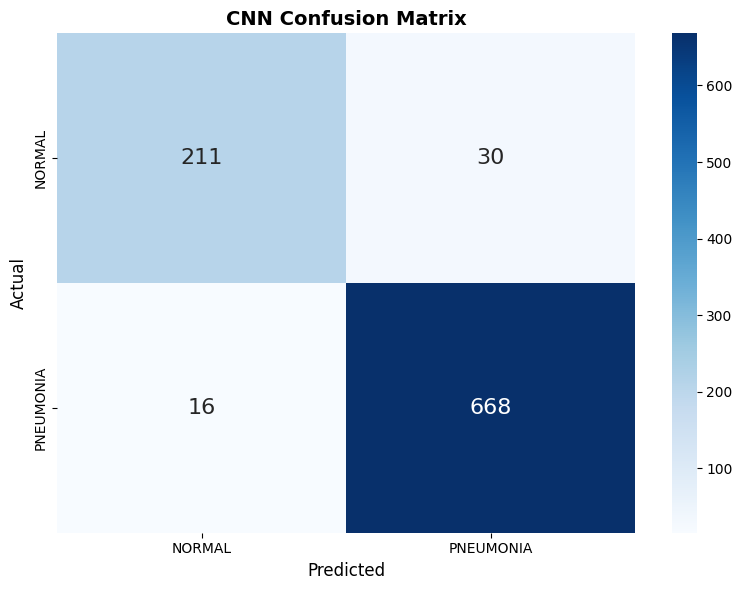

In [43]:

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["NORMAL", "PNEUMONIA"],
            yticklabels=["NORMAL", "PNEUMONIA"],
            annot_kws={"size": 16}, ax=ax)
ax.set_xlabel("Predicted", fontsize=12)
ax.set_ylabel("Actual", fontsize=12)
ax.set_title("CNN Confusion Matrix", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig("plots/confusion_matrix.png", dpi=150, bbox_inches="tight")
plt.show()

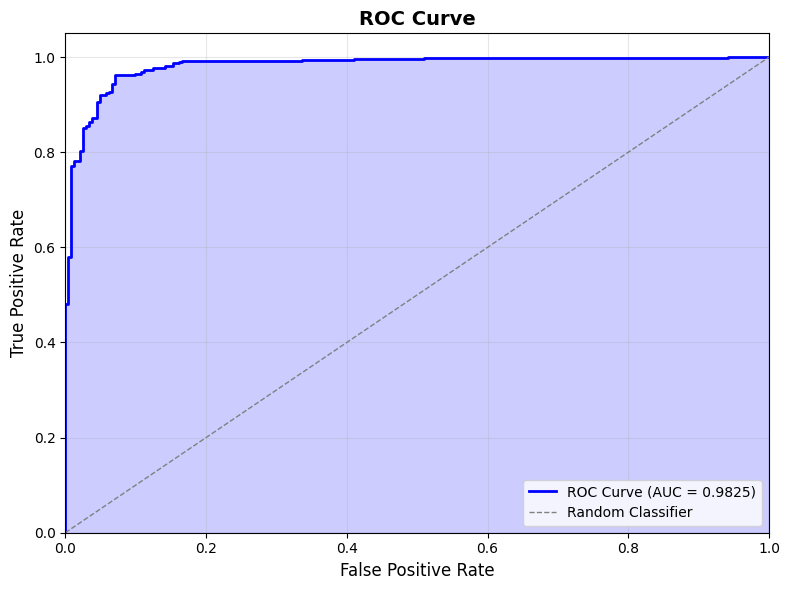

AUC Score: 0.9825


In [44]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
auc_score = roc_auc_score(all_labels, all_probs)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {auc_score:.4f})")
ax.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--", label="Random Classifier")
ax.fill_between(fpr, tpr, alpha=0.2, color="blue")
ax.set_xlabel("False Positive Rate", fontsize=12)
ax.set_ylabel("True Positive Rate", fontsize=12)
ax.set_title("ROC Curve", fontsize=14, fontweight="bold")
ax.legend(loc="lower right", fontsize=10)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.05])
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("plots/roc_curve.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"AUC Score: {auc_score:.4f}")

## Step 7: SVM Baseline Model with Unsupervised Feature Extraction (PCA)

In [45]:
from sklearn.svm import SVC
from PIL import Image
from tqdm import tqdm

def load_for_svm(dataframe, target_size):
    X_list = []
    y_list = []
    
    for _, row in tqdm(dataframe.iterrows(), total=len(dataframe), desc="Loading images"):
        filepath = row["filepath"]
        label = row["label"]
        
        img = Image.open(filepath).convert("RGB")
        img = img.resize(target_size, Image.Resampling.LANCZOS)
        
        img_array = np.array(img, dtype=np.float32) / 255.0
        img_flat = img_array.flatten()
        
        X_list.append(img_flat)
        y_list.append(1 if label == "PNEUMONIA" else 0)
    
    return np.array(X_list), np.array(y_list)

X_train_svm, y_train_svm = load_for_svm(df_train, target_size=(64, 64))

X_test_svm, y_test_svm = load_for_svm(df_test, target_size=(64, 64))

print(f"SVM Data shapes:\n")
print(f"  X_train_svm: {X_train_svm.shape}")
print(f"  y_train_svm: {y_train_svm.shape}")
print(f"  X_test_svm:  {X_test_svm.shape}")
print(f"  y_test_svm:  {y_test_svm.shape}")

Loading images: 100%|██████████| 925/925 [00:08<00:00, 108.61it/s]

SVM Data shapes:

  X_train_svm: (4081, 12288)
  y_train_svm: (4081,)
  X_test_svm:  (925, 12288)
  y_test_svm:  (925,)


In [46]:
pipeline = Pipeline([
    ('pca', PCA(n_components=0.95, random_state=42)),
    ('svm', SVC(probability=True, random_state=42)) 
])

param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train_svm, y_train_svm)

best_model = grid_search.best_estimator_

print(f"Best Parameters found: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

print("Evaluating on Test Set...")
y_pred_svm = best_model.predict(X_test_svm)

svm_accuracy = accuracy_score(y_test_svm, y_pred_svm)
svm_f1 = f1_score(y_test_svm, y_pred_svm)

print(f"Test Set Accuracy: {svm_accuracy:.4f}")
print(classification_report(y_test_svm, y_pred_svm, target_names=['NORMAL', 'PNEUMONIA']))


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters found: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.9392
Evaluating on Test Set...
Test Set Accuracy: 0.9481
              precision    recall  f1-score   support

      NORMAL       0.92      0.88      0.90       241
   PNEUMONIA       0.96      0.97      0.97       684

    accuracy                           0.95       925
   macro avg       0.94      0.93      0.93       925
weighted avg       0.95      0.95      0.95       925



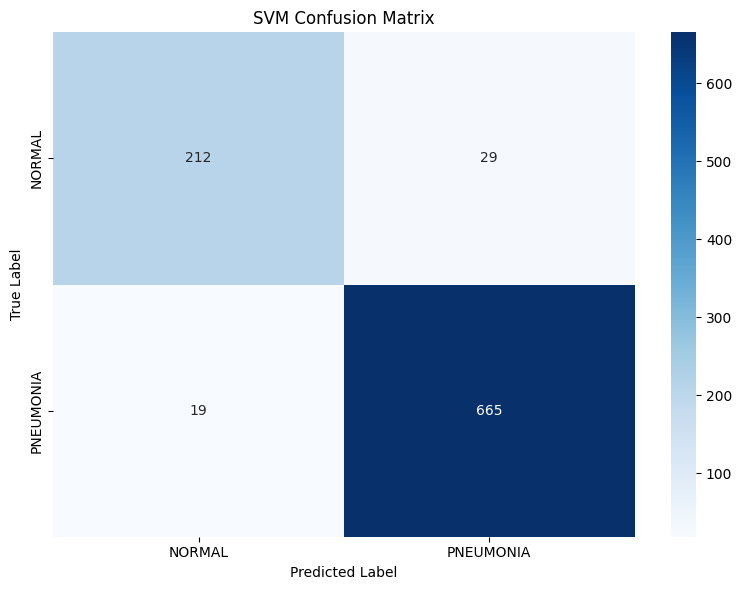

In [47]:
svm_cm = confusion_matrix(y_test_svm, y_pred_svm)

plt.figure(figsize=(8, 6))
sns.heatmap(
    svm_cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=['NORMAL', 'PNEUMONIA'],
    yticklabels=['NORMAL', 'PNEUMONIA']
)
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig("plots/svm_confusion_matrix.png", dpi=150, bbox_inches="tight")
plt.show()

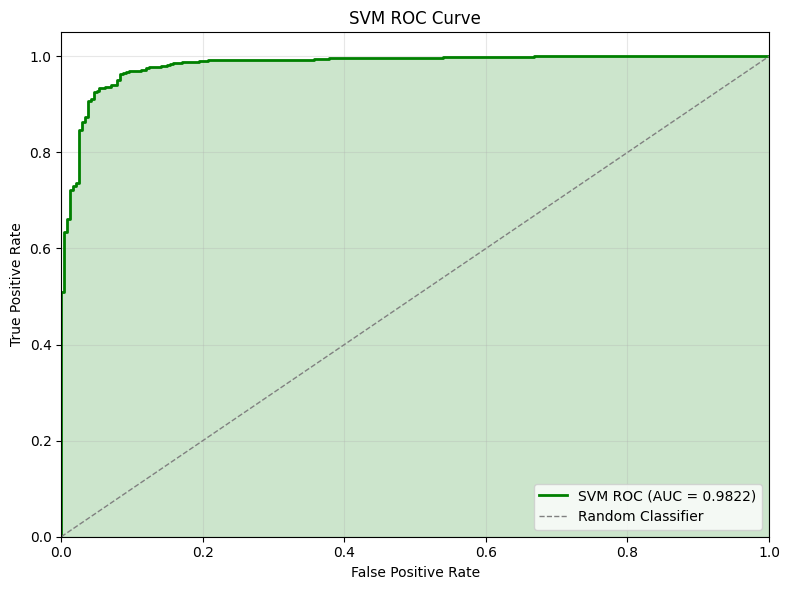

SVM AUC Score: 0.9822


In [48]:
svm_scores = best_model.decision_function(X_test_svm)
svm_fpr, svm_tpr, svm_thresholds = roc_curve(y_test_svm, svm_scores)
svm_auc = roc_auc_score(y_test_svm, svm_scores)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(svm_fpr, svm_tpr, color='green', lw=2, label=f'SVM ROC (AUC = {svm_auc:.4f})')
ax.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Classifier')
ax.fill_between(svm_fpr, svm_tpr, alpha=0.2, color='green')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('SVM ROC Curve')
ax.legend(loc='lower right')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.05])
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('plots/svm_roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'SVM AUC Score: {svm_auc:.4f}')


## Step 8: Model Comparison

Comparing the performance of the CNN model versus the SVM baseline model.

In [49]:
cnn_model = keras.models.load_model("models/chestxray_cnn_best.keras")

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col="filepath",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    shuffle=False
)

cnn_probs = cnn_model.predict(test_gen, verbose=0).flatten()
cnn_preds = (cnn_probs >= 0.5).astype(int)
cnn_labels = test_gen.classes

cnn_accuracy = accuracy_score(cnn_labels, cnn_preds)
cnn_f1 = f1_score(cnn_labels, cnn_preds)

comparison_df = pd.DataFrame({
    'Model': ['CNN', 'SVM'],
    'Accuracy': [cnn_accuracy, svm_accuracy],
    'F1-Score': [cnn_f1, svm_f1]
})

print("Model Comparison")
print(comparison_df.to_string(index=False))

Found 925 validated image filenames belonging to 2 classes.
Model Comparison
Model  Accuracy  F1-Score
  CNN  0.950270  0.966715
  SVM  0.948108  0.965167


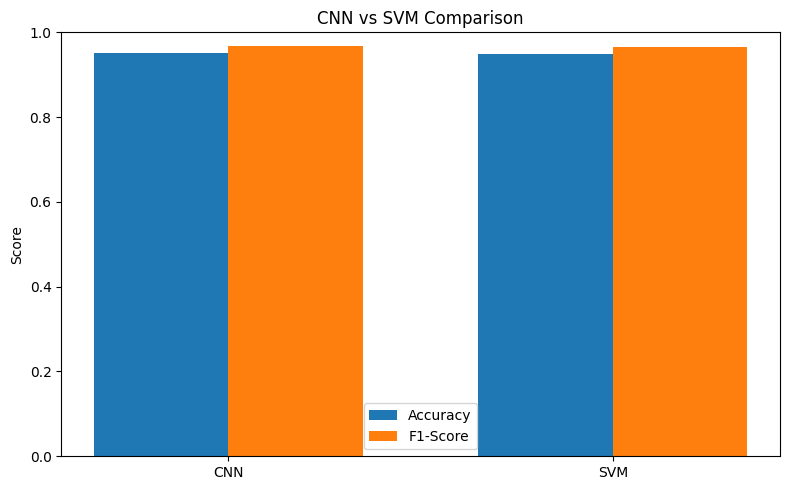

In [50]:
models = ['CNN', 'SVM']
x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, [cnn_accuracy, svm_accuracy], width, label='Accuracy')
ax.bar(x + width/2, [cnn_f1, svm_f1], width, label='F1-Score')

ax.set_ylabel('Score')
ax.set_title('CNN vs SVM Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1.0)
ax.legend()

plt.tight_layout()
plt.savefig("plots/model_comparison.png", dpi=150)
plt.show()

## Step 9: Single Image Prediction

In [51]:
def predict_image(image_path, model):
    img = keras.preprocessing.image.load_img(
        image_path, 
        target_size=(IMG_SIZE, IMG_SIZE)
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    prob = model.predict(img_array, verbose=0)[0][0]
    predicted_class = "PNEUMONIA" if prob >= 0.5 else "NORMAL"
    return predicted_class, prob

# Test on a few samples
test_samples = df_test.sample(n=4, random_state=42)

print("Sample Predictions:")
for idx, row in test_samples.iterrows():
    pred_class, pred_prob = predict_image(row["filepath"], model)
    actual_class = row["label"]
    match = "correct" if pred_class == actual_class else "wrong"
    print(f"  {os.path.basename(row['filepath'])}: Predicted={pred_class} ({pred_prob:.4f}), Actual={actual_class} [{match}]")

Sample Predictions:
  person1430_bacteria_3696.jpeg: Predicted=PNEUMONIA (0.9565), Actual=PNEUMONIA [correct]
  NORMAL2-IM-0352-0001.jpeg: Predicted=NORMAL (0.0601), Actual=NORMAL [correct]
  IM-0458-0001.jpeg: Predicted=NORMAL (0.0318), Actual=NORMAL [correct]
  person99_virus_183.jpeg: Predicted=PNEUMONIA (0.8334), Actual=PNEUMONIA [correct]
